# TensorTools Runtime Demo

Demonstrates the usage of the runtime using a simple autoencoder model.

In [1]:
# Force matplotlib to use inline rendering
%matplotlib inline

import os
import sys

# add path to libraries for ipython
sys.path.append(os.path.expanduser("~/libs"))

import numpy as np
import tensorflow as tf
import tensortools as tt

In [2]:
BATCH_SIZE = 24
REG_LAMBDA = 5e-4
NUM_GPUS = 2

In [3]:
dataset_train = tt.datasets.moving_mnist.MovingMNISTTrainDataset(BATCH_SIZE * NUM_GPUS,
                                                                 1)
dataset_valid = tt.datasets.moving_mnist.MovingMNISTValidDataset(BATCH_SIZE * NUM_GPUS,
                                                                 1)
#dataset_test = tt.datasets.moving_mnist.MovingMNISTTestDataset(BATCH_SIZE * NUM_GPUS,
#                                                               1)

File mnist.h5 has already been downloaded.
File mnist.h5 has already been downloaded.


In [4]:
class SimpleAutoencoderModel(tt.model.AbstractModel):
    """Simple neuronal autoencoder.
    """
    def __init__(self, inputs, targets, reg_lambda,
                 scope=None, is_training=False):
        self._scope = scope  # TODO: move to base class (call is device scope?)
        self._is_training = is_training  # TODO: move to base class
        super(SimpleAutoencoderModel, self).__init__(inputs, targets, reg_lambda)
    
    @tt.utils.attr.lazy_property
    def predictions(self):
        x = tf.contrib.layers.flatten(self._inputs)
        encoded = tt.network.fc("FC_Enc", x, 128,
                                weight_init=tf.contrib.layers.xavier_initializer(),
                                bias_init=0.0)
        representation = encoded
        decoded = tt.network.fc("FC_Dec", representation, self.input_shape[1] * self.input_shape[2] * self.input_shape[3],
                                weight_init=tf.contrib.layers.xavier_initializer(),
                                bias_init=0.0)
        
        return tf.reshape(decoded, [-1, 1, self.input_shape[2], self.input_shape[3], self.input_shape[4]])

    @tt.utils.attr.lazy_property
    def loss(self):
        return tt.loss.bce(self.predictions, self._targets)

In [5]:
runtime = tt.core.MultiGpuRuntime()
runtime.register_datasets(dataset_train, dataset_valid)
runtime.register_model(
    lambda x, y, scope, is_training : SimpleAutoencoderModel(x, y,
                                                             reg_lambda=REG_LAMBDA,
                                                             scope=scope,
                                                             is_training=is_training))
runtime.setup_feeding(tt.core.FEEDING_AUTOENCODER)
runtime.build()

In [6]:
runtime.train(steps=5000)

Starting epoch 1...
@    10: loss:     0.485, total-loss:     0.485 ( 2615.1 examples/sec,  0.02 sec/batch)
@    20: loss:     0.446, total-loss:     0.446 ( 3674.4 examples/sec,  0.01 sec/batch)
@    30: loss:     0.444, total-loss:     0.444 ( 3615.0 examples/sec,  0.01 sec/batch)
@    40: loss:     0.412, total-loss:     0.412 ( 2883.1 examples/sec,  0.02 sec/batch)
@    50: loss:     0.392, total-loss:     0.392 ( 3797.8 examples/sec,  0.01 sec/batch)
@    60: loss:     0.364, total-loss:     0.364 ( 4322.4 examples/sec,  0.01 sec/batch)
@    70: loss:     0.351, total-loss:     0.351 ( 2881.0 examples/sec,  0.02 sec/batch)
@    80: loss:     0.341, total-loss:     0.341 ( 4273.9 examples/sec,  0.01 sec/batch)
@    90: loss:     0.322, total-loss:     0.322 ( 5209.0 examples/sec,  0.01 sec/batch)
@   100: loss:     0.302, total-loss:     0.302 ( 3675.9 examples/sec,  0.01 sec/batch)

@   100: Starting validation (batch-size: 48, dataset-size: 10000):
9984/9984 [====================

In [ ]:
runtime.validate()

In [ ]:
runtime.test()

(24, 1, 64, 64, 1)


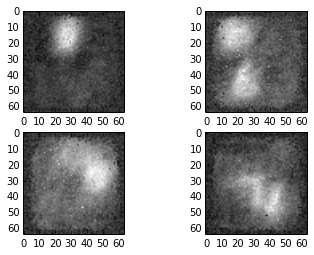

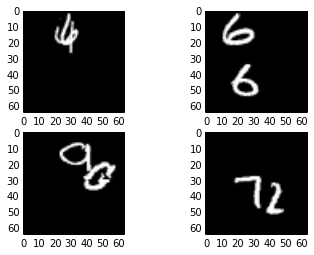

In [7]:
batch = dataset_valid.get_batch()
batch_x = batch[:,0:1,:,:,:]

predictions = runtime.predict(batch_x)
print(predictions.shape)

tt.visualization.display_batch(batch_x[0:4,0,:,:,:])
tt.visualization.display_batch(predictions[0:4,0,:,:,:])

In [ ]:
runtime.close()